In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
# import math
import torch

import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
data_path = '../data/all/VS-1-30'
scan_path = os.path.join(data_path, 'vs_gk_11')

In [3]:
t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))

In [4]:
idx = 0
t1 = torch.as_tensor(nib.load(t1_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
t2 = torch.as_tensor(nib.load(t2_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
seg = torch.as_tensor(nib.load(seg_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)

Text(0.5, 1.0, 'seg')

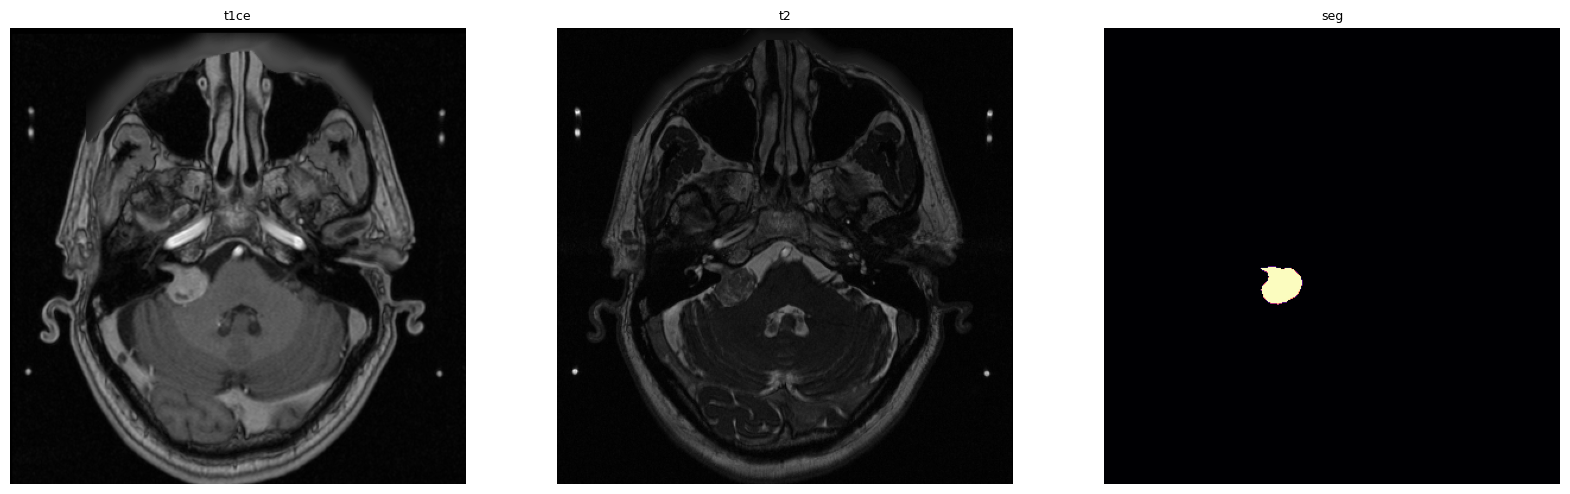

In [5]:
slice = 20

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(torch.rot90(t1[slice], 3), cmap="gray")
axs[0].axis("off")
axs[0].set_title("t1ce", fontsize=9)

axs[1].imshow(torch.rot90(t2[slice], 3), cmap="gray")
axs[1].axis("off")
axs[1].set_title("t2", fontsize=9)

axs[2].imshow(torch.rot90(seg[slice], 3), cmap="magma")
axs[2].axis("off")
axs[2].set_title("seg", fontsize=9)

(-0.5, 383.5, 383.5, -0.5)

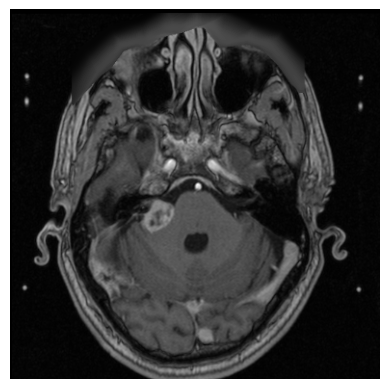

In [6]:
slice = 23

plt.imshow(torch.rot90(t1[slice], 3), cmap="gray")
plt.axis("off")
# plt.set_title("t1ce", fontsize=9)

(-0.5, 383.5, 383.5, -0.5)

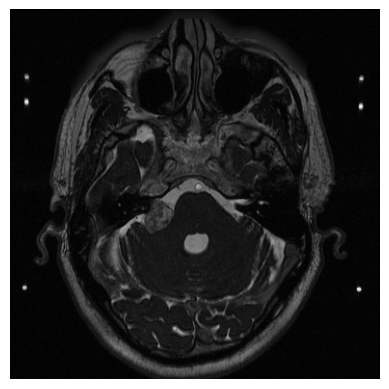

In [7]:
plt.imshow(torch.rot90(t2[slice], 3), cmap="gray")
plt.axis("off")
# plt.set_title("t2", fontsize=9)

(-0.5, 383.5, 383.5, -0.5)

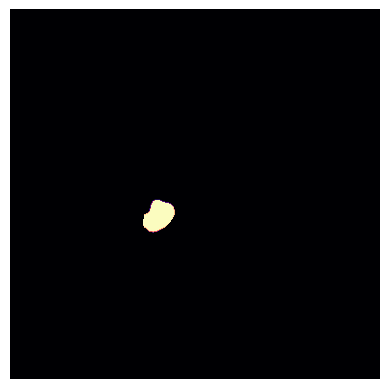

In [8]:
plt.imshow(torch.rot90(seg[slice], 3), cmap="magma")
plt.axis("off")
# plt.set_title("seg", fontsize=9)

In [9]:
def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    glioma_indices = torch.nonzero((mask > 0))[:, 1]
    if len(glioma_indices) == 0:
        return 0, 0

    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last

def plot_tumour(mask: torch.Tensor):
    """Plot individual slices of the tumour in one figure."""
    
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(mask)
    print("Tumour indices: ", first, last)

    length = last - first + 1
    n_graphs = (length) // 4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0
    for i in range(first, last):
        if j >= len(axs):
            break
        axs[j].imshow(mask[0, i, :, :], cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(f"mask slice {i}", fontsize=9)
        j += 1

    plt.show()


In [10]:
import sys
sys.path.append("../")
from src.model.segmentation import Unet
from src.data.data_generator import MRIDataset
from src.losses.dice import dice_coefficient
import csv
import re
import pandas as pd

In [17]:
data_dir = '../data/all/'
t1_list = sorted(glob.glob(os.path.join(data_dir, "VS-*-*/vs_*/*_t1_*")))
t2_list = sorted(glob.glob(os.path.join(data_dir, "VS-*-*/vs_*/*_t2_*")))
seg_list = sorted(glob.glob(os.path.join(data_dir, "VS-*-*/vs_*/*_seg_*")))

In [18]:
new_data = MRIDataset(
    t1_list, t2_list, seg_list, (40, 256, 256), clicks=None
)

In [19]:
masks_combined = torch.zeros((40, 256, 256))

In [21]:
for i in range(len(new_data)):
  print(f'scan: {i}')
  _, y = new_data[i]
  masks_combined += y[0]

scan: 0
scan: 1
scan: 2
scan: 3
scan: 4
scan: 5
scan: 6
scan: 7
scan: 8
scan: 9
scan: 10
scan: 11
scan: 12
scan: 13
scan: 14
scan: 15
scan: 16
scan: 17
scan: 18
scan: 19
scan: 20
scan: 21
scan: 22
scan: 23
scan: 24
scan: 25
scan: 26
scan: 27
scan: 28
scan: 29
scan: 30
scan: 31
scan: 32
scan: 33
scan: 34
scan: 35
scan: 36
scan: 37
scan: 38
scan: 39
scan: 40
scan: 41
scan: 42
scan: 43
scan: 44
scan: 45
scan: 46
scan: 47
scan: 48
scan: 49
scan: 50
scan: 51
scan: 52
scan: 53
scan: 54
scan: 55
scan: 56
scan: 57
scan: 58
scan: 59
scan: 60
scan: 61
scan: 62
scan: 63
scan: 64
scan: 65
scan: 66
scan: 67
scan: 68
scan: 69
scan: 70
scan: 71
scan: 72
scan: 73
scan: 74
scan: 75
scan: 76
scan: 77
scan: 78
scan: 79
scan: 80
scan: 81
scan: 82
scan: 83
scan: 84
scan: 85
scan: 86
scan: 87
scan: 88
scan: 89
scan: 90
scan: 91
scan: 92
scan: 93
scan: 94
scan: 95
scan: 96
scan: 97
scan: 98
scan: 99
scan: 100
scan: 101
scan: 102
scan: 103
scan: 104
scan: 105
scan: 106
scan: 107
scan: 108
scan: 109
scan: 110


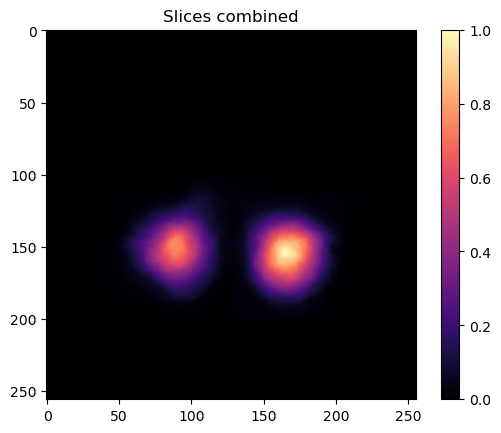

In [22]:
summed = torch.sum(masks_combined, axis=0)
a = summed / summed.max()

plt.imshow(a.rot90(3), cmap='magma')
plt.title('Slices combined')
cb = plt.colorbar()
plt.show()

In [88]:
x, y = new_data[2]

(-0.5, 255.5, 255.5, -0.5)

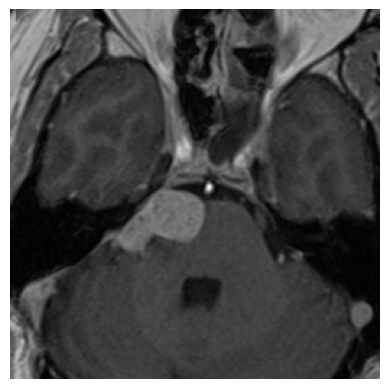

In [89]:
plt.imshow(torch.rot90(x[0,20], 3), cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

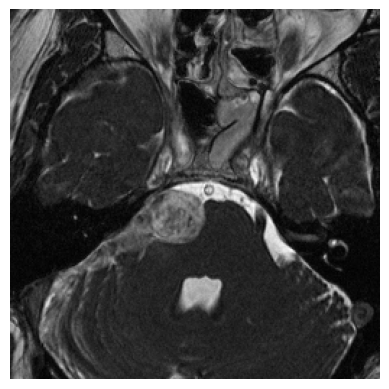

In [90]:
plt.imshow(torch.rot90(x[1,20], 3), cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

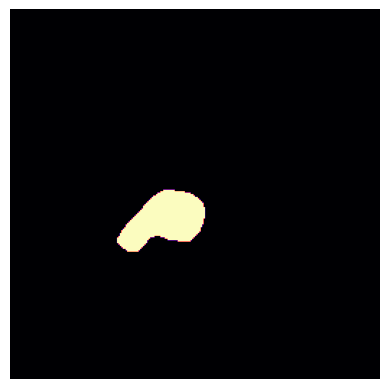

In [91]:
plt.imshow(torch.rot90(y[0,20], 3), cmap='magma')
plt.axis('off')

In [16]:
model_path = "../models/pretraining_focaltversky_32imgs"
# os.listdir(model_path)

model = Unet(in_channels=2, out_channels=1, blocks=3).to("cpu")
checkpoint = torch.load(os.path.join(model_path, "best.pt"), map_location="cpu")
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [17]:
x, y = new_data[0]

In [18]:
with torch.no_grad():
    y_pred = model(x.unsqueeze(0))

Tumour indices:  15 29


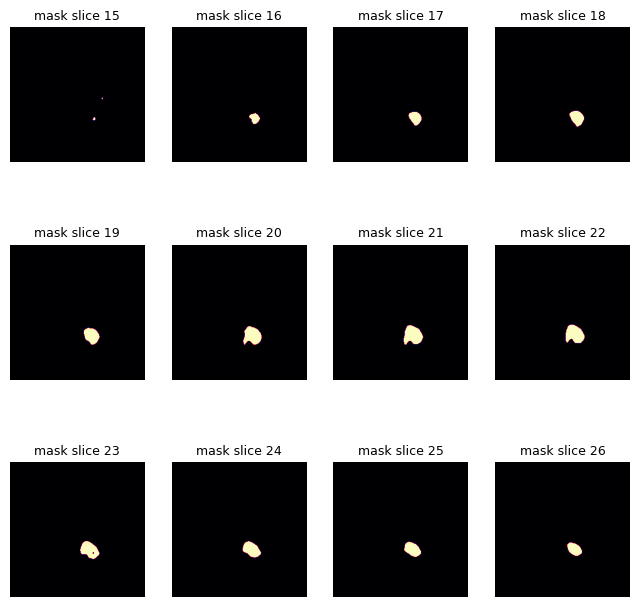

In [19]:
y_threshed = (y_pred > 0.6).type(torch.float32)
plot_tumour(y_threshed[0])

Tumour indices:  16 29


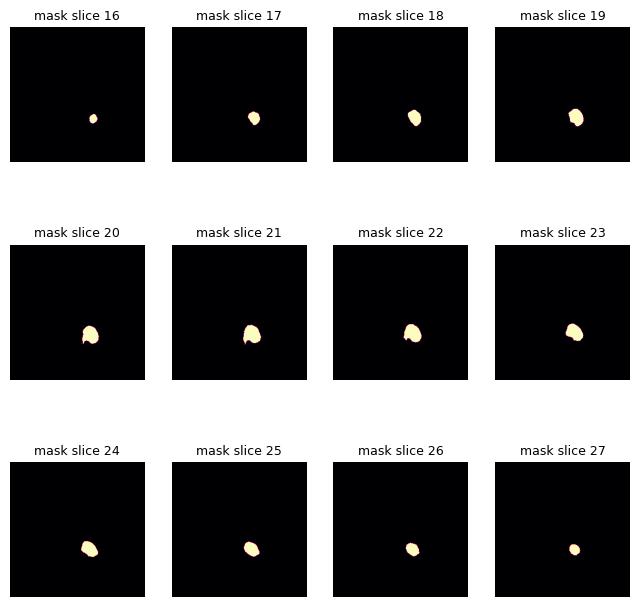

In [20]:
plot_tumour(y)

(-0.5, 255.5, 255.5, -0.5)

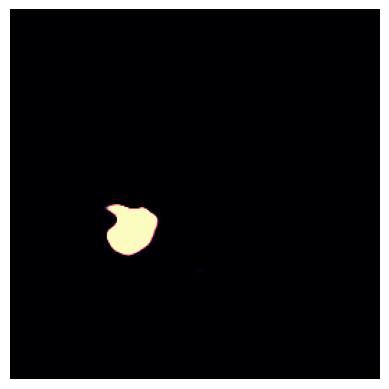

In [21]:
plt.imshow(torch.rot90(y_pred[0,0,20], 3), cmap='magma')
plt.axis('off')

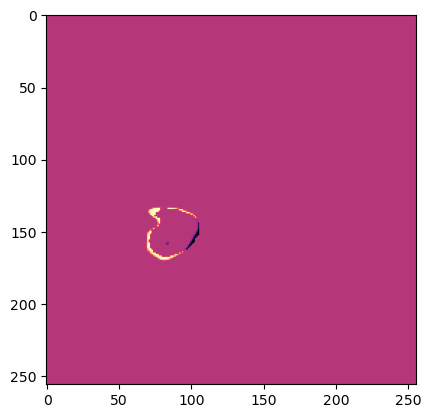

In [22]:
plt.imshow(torch.rot90(y_pred[0,0,22] - y[0,22], 3), cmap='magma')

In [23]:
clicks = torch.zeros_like(y_pred)
clicks[0,0,22,150,152] = 1
clicks[0,0,22,182,136] = 1

In [24]:
fig = px.imshow(torch.rot90(y_pred[0,0,22]+clicks[0,0,22], 3))
fig.show()

In [25]:
fig = px.imshow(y_pred[0,0,22] - y[0,22])
fig.show()

In [38]:
def cut_volume(seg: torch.Tensor, cut_size=32, num: int = np.inf) -> list[torch.Tensor]:
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(seg[1])

    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        # Cut the volume based on the specified cut size
        cut = torch.clone(seg[0][coords[0]])
        cut = cut[
            coords[1] - cut_size : coords[1] + cut_size,
            coords[2] - cut_size : coords[2] + cut_size,
        ].unsqueeze(0)
        
        cuts.append(cut)

    return cuts

In [39]:
y_threshed = y_threshed.squeeze(0)
clicks = clicks.squeeze(0)

In [45]:
cuts = cut_volume(torch.stack((y_threshed, clicks)), cut_size=48)

In [40]:
x.shape

torch.Size([2, 40, 256, 256])

In [46]:
t1_cuts = cut_volume(torch.stack((x[0].squeeze(0), clicks.squeeze(0))), cut_size=48)
t2_cuts = cut_volume(torch.stack((x[1].squeeze(0), clicks.squeeze(0))), cut_size=48)
# t1_cuts.shape

In [47]:
true_cuts = cut_volume(torch.stack((y[0], clicks.squeeze(0))), cut_size=48)

In [48]:
def plot_cut(cut, cmap='magma', plot_mid=True):
    tmp_cut = torch.clone(cut)
    if plot_mid:
        tmp_cut[tmp_cut == 1] = 2
        tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 1
    plt.imshow(tmp_cut, cmap=cmap)
    plt.axis('off')

In [49]:
cuts[0][0].shape

torch.Size([48, 48])

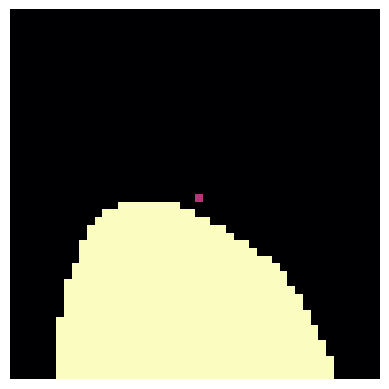

In [50]:
plot_cut(cuts[0][0])

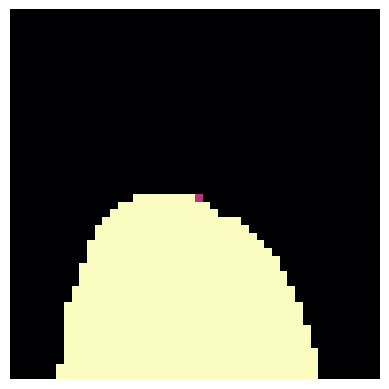

In [51]:
plot_cut(true_cuts[0][0])

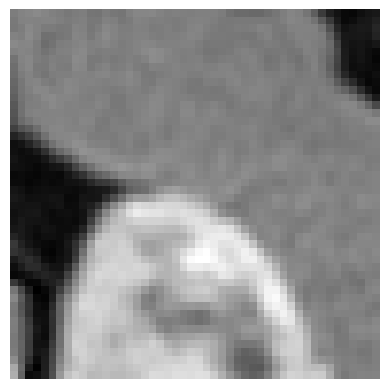

In [52]:
plot_cut(t1_cuts[0][0], plot_mid=False, cmap='gray')

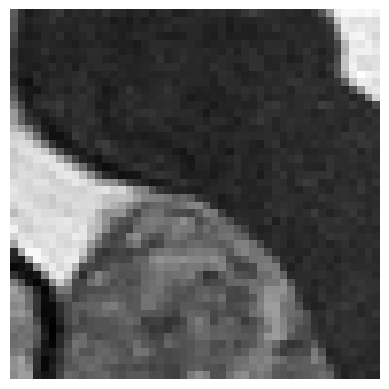

In [53]:
plot_cut(t2_cuts[0][0], plot_mid=False, cmap='gray')

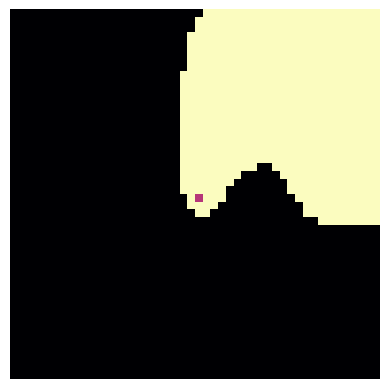

In [54]:
plot_cut(cuts[1][0])

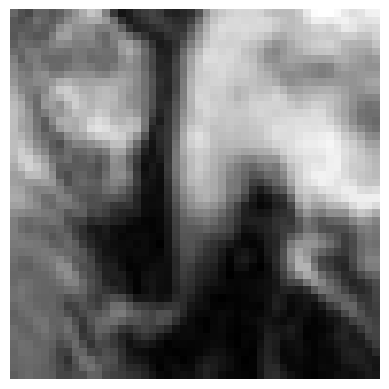

In [55]:
plot_cut(t1_cuts[1][0], plot_mid=False, cmap='gray')

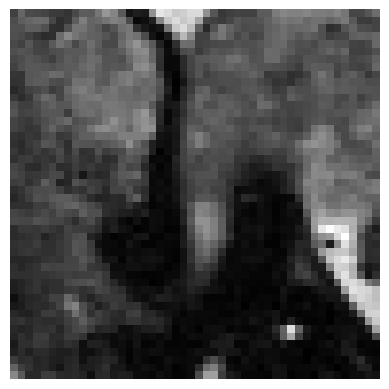

In [56]:
plot_cut(t2_cuts[1][0], plot_mid=False, cmap='gray')

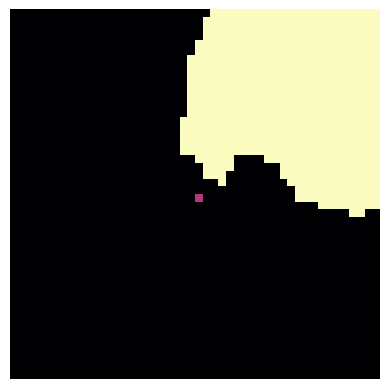

In [57]:
plot_cut(true_cuts[1][0])

In [ ]:
# clicks = torch.zeros_like(y_pred)

# clicks[22,150:155,152:157] = 1
# clicks[22,182:187,136:141] = 1
# plt.imshow(torch.rot90(clicks[22], 3), cmap="magma")
# plt.axis('off')

In [153]:
from src.model.correction import CorrectionUnet
from src.data.correction_generator import CorrectionMRIDataset, CorrectionDataLoader

In [53]:
correction_model_path = "../models/correctionloss_stronger_errors_hidden_augment"
correction_model = CorrectionUnet(in_channels=1, out_channels=1, blocks=3).to("mps")

checkpoint = torch.load(os.path.join(correction_model_path, "best.pt"), map_location="mps")
correction_model.load_state_dict(checkpoint["model_state"])

NameError: name 'CorrectionUnet' is not defined

In [228]:
cuts[0].shape

torch.Size([1, 32, 32])

In [230]:
with torch.no_grad():
    x_cut1 = cuts[0].to('mps')
    pred_cut1 = correction_model(x_cut1.unsqueeze(0))

    x_cut2 = cuts[1].to('mps')
    pred_cut2 = correction_model(x_cut2.unsqueeze(0))

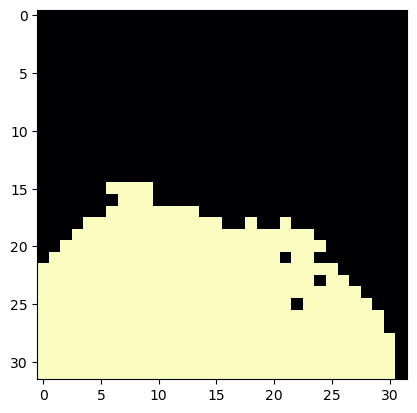

In [235]:
pred_cut1 = (pred_cut1 > 0.6).type(torch.float32).cpu()
plt.imshow(pred_cut1[0,0], cmap="magma")

In [238]:
fig = px.imshow(cuts[0][0] - pred_cut1[0][0])
fig.show()

In [241]:
fig = px.imshow(cuts[0][0] - true_cuts[0][0])
fig.show()

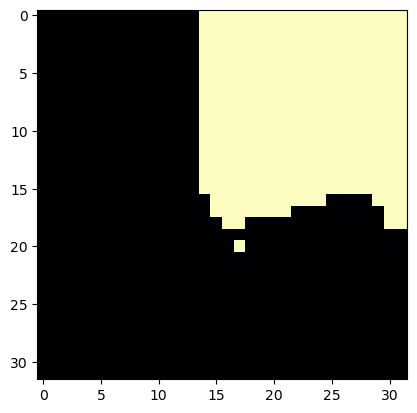

In [231]:
pred_cut2 = (pred_cut2 > 0.6).type(torch.float32).cpu()
plt.imshow(pred_cut2[0,0], cmap="magma")

In [260]:
fig = px.imshow(pred_cut2[0][0] - cuts[1][0])
fig.show()

In [259]:
fig = px.imshow(cuts[1][0] - true_cuts[1][0])
fig.show()

In [303]:
def reconstruct_volume(seg: torch.Tensor, cuts, cut_size=32, num: int = np.inf) -> list[torch.Tensor]:
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(seg[1])

    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]
        
        cut = cuts[click_idx]
        seg[0, coords[0], coords[1] - cut_size : coords[1] + cut_size, coords[2] - cut_size : coords[2] + cut_size] = cut 

    return seg

In [304]:
clicks = torch.zeros_like(y_threshed)
clicks[22,150,152] = 1
clicks[22,182,136] = 1

In [305]:
new_cuts = list([pred_cut1.squeeze(0), pred_cut2.squeeze(0)])
# new_cuts[0]

In [306]:
reconstructed_seg = reconstruct_volume(
    torch.stack((y_threshed, clicks)), 
    cuts=new_cuts
)
# cuts = cut_volume(torch.stack((y_threshed, clicks)))

Text(0.5, 1.0, 'y')

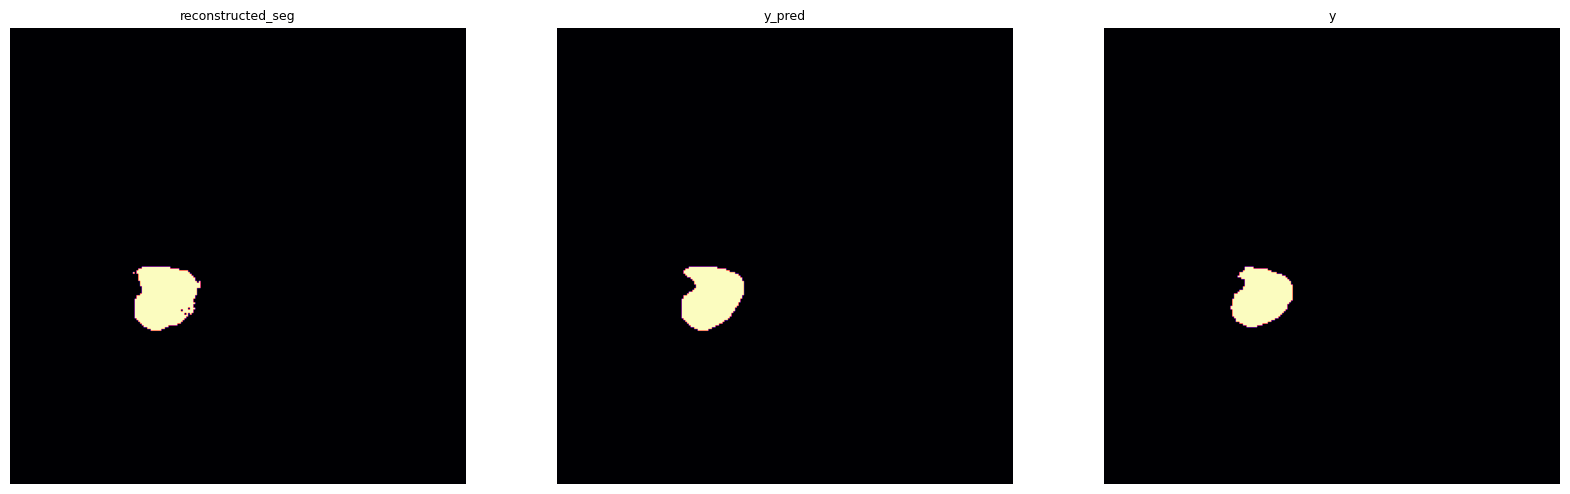

In [311]:
slice = 22

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(torch.rot90(reconstructed_seg[0,22], 3), cmap="magma")
axs[0].axis("off")
axs[0].set_title("reconstructed_seg", fontsize=9)

axs[1].imshow(torch.rot90(y_threshed[slice], 3), cmap="magma")
axs[1].axis("off")
axs[1].set_title("y_pred", fontsize=9)

axs[2].imshow(torch.rot90(y[0,slice], 3), cmap="magma")
axs[2].axis("off")
axs[2].set_title("y", fontsize=9)

In [332]:
dice_coefficient(reconstructed_seg[0, 22], y[0, 22])

tensor(0.8945)

In [333]:
dice_coefficient(y_threshed[22], y[0,22])

tensor(0.9140)